In [ ]:
from gbdxtools.task import env
from gbdxtools import CatalogImage
%matplotlib inline

catalog_id = env.inputs.get('catalog_id', '1040010032118200')
bbox = env.inputs.get('bbox', '-43.26416015625001, -22.950014703118647, -43.121337890625, -22.873523987658665')

image = CatalogImage(catalog_id, band_type="MS", bbox=map(float, bbox.split(",")))
image.plot(w=10, h=10)

Fetching Image... 989 tiles


In [ ]:
from gbdxtools.task import env
from gbdxtools import CatalogImage
%matplotlib inline

catalog_id = env.inputs.get('catalog_id', '1040010038674A00')
bbox = env.inputs.get('bbox', '139.65888977050784, 35.61223244843531, 139.85046386718753, 35.739342890089965')

image = CatalogImage(catalog_id, band_type="MS", bbox=map(float, bbox.split(",")))
image.plot(w=10, h=10)

Fetching Image... 3060 tiles


In [ ]:
from gbdxtools.task import env
from gbdxtools import CatalogImage
%matplotlib inline

catalog_id = env.inputs.get('catalog_id', '104001003918D000')
bbox = env.inputs.get('bbox', '4.845930933952332, 52.36460466219462, 4.846714138984681, 52.36514487726674')

image = CatalogImage(catalog_id, band_type="MS", bbox=map(float, bbox.split(",")),pansharpen=True)
image.plot(w=10, h=10)

Fetching Image... 2 tiles


Fetching Image... 1 tile


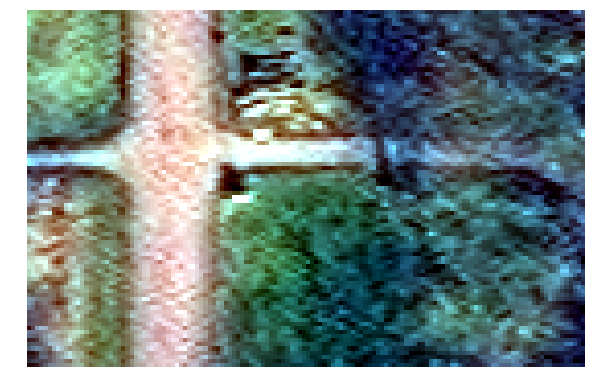

In [15]:
from gbdxtools.task import env
from gbdxtools import CatalogImage
%matplotlib inline

catalog_id = env.inputs.get('catalog_id', '104001003918D000')
bbox = env.inputs.get('bbox', '4.847669005393983, 52.36183024120656, 4.848082065582276, 52.36209218093868')

image = CatalogImage(catalog_id, band_type="MS", bbox=map(float, bbox.split(",")),pansharpen=True)
image.plot(w=10, h=10)

Fetching Image... 1 tile


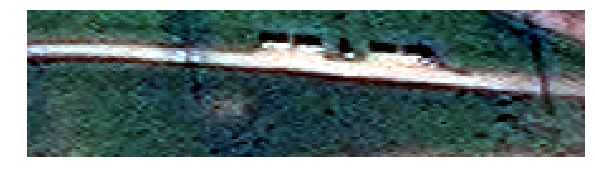

In [2]:
from gbdxtools.task import env
from gbdxtools import CatalogImage
%matplotlib inline

catalog_id = env.inputs.get('catalog_id', '104001003918D000')
bbox = env.inputs.get('bbox', '4.845877289772035, 52.36343191847954, 4.846547842025758, 52.363608721559686')

image = CatalogImage(catalog_id, band_type="MS", bbox=map(float, bbox.split(",")),pansharpen=True)
image.plot(w=10, h=10)

In [3]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import box, shape
from gbdxtools import Interface
from gbdxtools import CatalogImage
from gbdxtools.task import env
from shapely.ops import cascaded_union
import fiona
from shapely.geometry import mapping, Polygon
import matplotlib.pyplot as plt
import numpy as np
from skimage import filters, morphology
import gdal
import ogr, osr
from rasterio.plot import show

# connect to gbdx
gbdx = Interface()

In [4]:
#get image
catalog_id = env.inputs.get('catalog_id', '1030050045F94600')
bbox = env.inputs.get('bbox', '4.795532226562501, 52.36496281504866, 4.888916015625001, 52.41487819320523')

image = CatalogImage(catalog_id, band_type="MS", bbox=map(float, bbox.split(",")))

# calculate water index and ndvi

rgb = image.rgb()
coastal = image[0,:,:].astype(np.float32)
red = image[4,:,:].astype(np.float32)
nir = image[6,:,:].astype(np.float32)
nir2 = image[7,:,:].astype(np.float32)
water_index = (nir2 - coastal)/(nir2 + coastal)
ndvi = np.clip((nir - red)/(nir + red), -1, 1)
A= ndvi >= 0.6
B = ndvi.all() >= 0.3 and ndvi.all() < 0.6
C= ndvi < 0.3
plants= A*2+B*3+C

# First, clean up any nan values
water_index[np.isnan(water_index)] = 0

# Next, run a gaussian smoothing kernel over the image. This will smooth out localized noise in the water index
# by use a focal moving window.
water_index_smoothed = filters.gaussian(water_index, preserve_range=True)

# Finally, we are going to run the thresholding. We are going to use a method called Otsu's method,
# which picks the threshold that will maximize the variance between the values on either side of it.
# For more info on Otsu's Method, see: 
# http://scikit-image.org/docs/dev/auto_examples/xx_applications/plot_thresholding.html
# and http://en.wikipedia.org/wiki/Otsu’s_method.


# Find the threshold
binary_threshold = -0.65 

# Apply the threshold
binary_water = water_index_smoothed >= binary_threshold

# Specify the minimum feature size in square meters, and then use info from the image metadata 
# to translate to grid cell count.

# Set the minimum feature size to 400 sq km (400,000 m)
min_feature_size_m2 = 40000.

# From the image metadata, we can determine the area of a single grid cell
cell_height_m = image.ipe.metadata['image']['groundSampleDistanceMeters']
cell_area_m2 = cell_height_m**2

# Finally, use the cell size to convert the minimum feature size to grid cells
min_feature_size_cells = np.round((min_feature_size_m2/cell_area_m2)).astype('int64')

# First, remove the small holes
water_cleaned = morphology.remove_small_holes(binary_water, min_feature_size_cells)

# Then remove the small objects
water_cleaned = morphology.remove_small_objects(water_cleaned, min_feature_size_cells, connectivity=2)

# marge layers
all_layers = plants+water_cleaned*3

Fetching Image... 153 tiles


In [5]:
def plot(image, w=15, h=12, cmap='jet'):
    f, ax = plt.subplots(1, figsize=(w,h))
    ax.axis('on')
    plt.imshow(image, cmap=cmap)
    plt.colorbar()
    plt.show()


In [6]:
# convert the bounding box into a well-known text format
bbox = [4.795532226562501, 52.36496281504866, 4.888916015625001, 52.41487819320523]
bbox_wkt = box(*bbox).wkt

# (results come back formatted as geojson)
parks_geojson = gbdx.vectors.query(bbox_wkt, query="ingest_source:OSM AND item_type:Park", index="vector-osm-*")

# how many are there?
print 'Number of Park features:', len(parks_geojson)



Number of Park features: 54


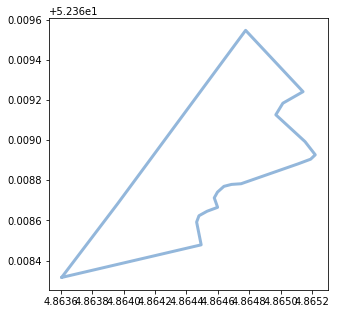

In [7]:

park_nr = 2;

# convert each geojson into a Shapely geometry object
geom_list = []
for geojson in parks_geojson:
    geom = shape(geojson['geometry']);
    geom_list.append(geom);
    
# number polygons items in list
len(geom_list);

# transform shapely to GeJSON format
geoms = [mapping(geom_list[park_nr])];

# get exterior xy values from shapely object
x,y = geom_list[park_nr].exterior.xy;

fig = plt.figure(figsize=(5,5));
ax = fig.add_subplot(111);
ax.plot(x, y, color='#6699cc', alpha=0.7,
    linewidth=3, solid_capstyle='round', zorder=2);
# rasterio.plot.show(raster.read(1));





Fetching Image... 289 tiles


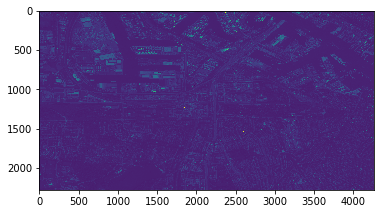

In [8]:
#   '4.795532226562501,4.888916015625001, 52.36496281504866,52.41487819320523'
plt.imshow(image[1,:,:].read())

In [9]:
## create geotiff

#  Initialize the Image Size
image_size = all_layers.shape

#  Choose some Geographic Transform 
lat = [52.36496281504866,52.41487819320523]
lon = [4.795532226562501,4.888916015625001]

#  Create Each Channel
pixels = all_layers

r_pixels = image[1,:,:].read(dtype=np.uint8)
g_pixels = image[2,:,:].read(dtype=np.uint8)
b_pixels = image[3,:,:].read(dtype=np.uint8)


# set geotransform
nx = image_size[0]
ny = image_size[1]
xmin, ymin, xmax, ymax = [min(lon), min(lat), max(lon), max(lat)]
xres = (xmax - xmin) / float(nx)
yres = (ymax - ymin) / float(ny)
geotransform = (xmin, xres, 0, ymax, 0, -yres)

# create the 3-band raster file
dst_ds = gdal.GetDriverByName('GTiff').Create('raster_files/myGeoTIFF.tif', ny, nx, 3, gdal.GDT_Byte)

dst_ds.SetGeoTransform(geotransform)       # specify coords
srs = osr.SpatialReference()               # establish encoding
srs.ImportFromEPSG(4326)                   # WGS84 lat/long
dst_ds.SetProjection(srs.ExportToWkt())    # export coords to file


dst_ds.GetRasterBand(1).WriteArray(r_pixels)   # write r-band to the raster
dst_ds.GetRasterBand(2).WriteArray(g_pixels)   # write g-band to the raster
dst_ds.GetRasterBand(3).WriteArray(b_pixels)   # write b-band to the raster

dst_ds.FlushCache()                        # write to disk


Fetching Image... 289 tiles
Fetching Image... 289 tiles
Fetching Image... 289 tiles


In [10]:
raster = rasterio.open('raster_files/myGeoTIFF.tif')
shapefile = fiona.open("shapefiles/my_shp2.shp", "r")


In [11]:
with rasterio.open("raster_files/myGeoTIFF.tif") as src:
     out_image, out_transform = mask(src, geoms, crop=True)

ValueError: Input shapes do not overlap raster.

In [ ]:
raster.read()

In [ ]:
# get exterior xy values from shapely object
x,y = geom_list[park_nr].exterior.xy;

fig = plt.figure(figsize=(5,5));
ax = fig.add_subplot(111);
ax.plot(x, y, color='#6699cc', alpha=0.7,
    linewidth=3, solid_capstyle='round', zorder=2);
# rasterio.plot.show(raster.read(1));

y

In [ ]:
import os
from functools import partial
import pyproj
from shapely.ops import transform

aoi = box(4.795532226562501,4.888916015625001, 52.36496281504866,52.41487819320523)

reproj = partial(pyproj.transform, pyproj.Proj(init="EPSG:4326"), pyproj.Proj(init="EPSG:3857"))

index_name = ''.join(map(str, aoi.bounds))
if not os.path.exists('{}.dat'.format(index_name)):
    osm_index = SpatialIndex(index_name)
    for idx, rec in enumerate(osm_data):
        osm_index.add(idx, transform( reproj, shape(rec["geometry"])).bounds, rec)
    osm_index.close()
    
osm_index = SpatialIndex(index_name)

def lookup_basis_vector(g):
    features = [rec.object for rec in osm_index.intersection(g.bounds, objects=True)]
    return basis_vector(features)

In [5]:

import numpy as np

# Calculate the water index
water_index = (image[7,:,:] - image[0,:,:]) / (image[7,:,:] + image[0,:,:])

# Also extract the visible color (i.e., Red-Green-Blue) bands, which we'll use for side-by-side plotting as we proceed
rgb = image.rgb()

# calculate water index and ndvi

rgb = image.rgb()
coastal = image[0,:,:].astype(np.float32)
red = image[4,:,:].astype(np.float32)
nir = image[6,:,:].astype(np.float32)
nir2 = image[7,:,:].astype(np.float32)

water_index = (nir2 - coastal)/(nir2 + coastal)

ndvi = np.clip((nir - red)/(nir + red), -1, 1)
A = ndvi >= 0.6
B = ndvi.all() >= 0.3 and ndvi.all() < 0.6
C = ndvi < 0.3
plants= A*2+B*3+C

# First, clean up any nan values
water_index[np.isnan(water_index)] = 0

# Next, run a gaussian smoothing kernel over the image. This will smooth out localized noise in the water index
# by use a focal moving window.
water_index_smoothed = filters.gaussian(water_index, preserve_range=True)

# Finally, we are going to run the thresholding. We are going to use a method called Otsu's method,
# which picks the threshold that will maximize the variance between the values on either side of it.
# For more info on Otsu's Method, see: 
# http://scikit-image.org/docs/dev/auto_examples/xx_applications/plot_thresholding.html
# and http://en.wikipedia.org/wiki/Otsu’s_method.


# Find the threshold
binary_threshold = -0.65 

# Apply the threshold
binary_water = water_index_smoothed >= binary_threshold
# Specify the minimum feature size in square meters, and then use info from the image metadata 
# to translate to grid cell count.

# Set the minimum feature size to 400 sq km (400,000 m)
min_feature_size_m2 = 40.

# From the image metadata, we can determine the area of a single grid cell
cell_height_m = image.ipe.metadata['image']['groundSampleDistanceMeters']
cell_area_m2 = cell_height_m**2

# Finally, use the cell size to convert the minimum feature size to grid cells
min_feature_size_cells = np.round((min_feature_size_m2/cell_area_m2)).astype('int64')

# First, remove the small holes
water_cleaned = morphology.remove_small_holes(binary_water, min_feature_size_cells)

# Then remove the small objects
water_cleaned = morphology.remove_small_objects(water_cleaned, min_feature_size_cells, connectivity=2)

# Combine all layers for easier analysis
all_layers = plants+water_cleaned*3



Fetching Image... 1 tile
Fetching Image... 1 tile


NameError: name 'filters' is not defined